# Analysis Grand Challenge of the PHYSLITE data format

This notebook is written as the result of a project of the IRIS-HEP summer fellowship programme. The web page, dedicated to the project, can be found via the [link](https://iris-hep.org/fellows/Denys-Klekots.html).

This code is heavily based on the Analysis Grand Challenge (AGC) of the CMS Open Data $t\bar{t}$. There is a link to the corresponding [GitHub repository](https://github.com/alexander-held/PyHEP-2022-AGC) written by Alexander Held.

Here we will use scientific Python infrastructure, which allows us to read data from the file and further analyse it. The data in high-energy physics is usually stored on an event-by-event basis and contains information on the detected particles. As there is an arbitrary number of particles for each event, we will use the `awkward` Python tools which allow us to handle arrays with an arbitrary length. The PHYSLITE format is stored inside a widely used in higher energy physics `*.root` file format and can be read by using the `coffee` python package. Also, the different events in high-energy physics are independent of each other, which allows for parallel computation and distribution over the cluster, the `dask` python package allows one to handle parallel computations.

In [1]:
import os
from pathlib import Path
import datetime

import uproot
import awkward as ak
import dask
import cabinetry
import dask_awkward as dak
import numpy as np
import hist.dask

import warnings
warnings.filterwarnings("ignore")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools


from dask.distributed import Client, performance_report

# create a folder for output tracking of uproot.open setup
MEASUREMENT_PATH = Path(datetime.datetime.now().strftime("measurements/%Y-%m-%d_%H-%M-%S"))
os.makedirs(MEASUREMENT_PATH)

# Set up the client distribution calculation for coffea-opendata.casa. Change the URL for UChicago
client = Client("tls://localhost:8786")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


The PHYSLITE files used for this analysis contain a lot of information, organised in brunches, a description of which can be accessed via the [link](https://atlas-physlite-content-opendata.web.cern.ch/). For the purpose of this specific analysis, a few of them are used and a filter is applied to select used ones.

In [2]:
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu",
        
        "EventInfoAuxDyn.mcEventWeights",
        ]

The code in the cell below will read the data from the file in a function NanoEventsFactory.from_root and produce an awkward array which is named events in this code. Here the PHYSLITESchema is specified to correspond to the format of the data and filter which was discussed above. Also the delayed computation is specified, which make computation in a single go.

The file used in the next cell is one of the Montecarlo-generated files for the $t \bar{t}$ pair physical processed. See the code below for more information and a reference to the file.

In [3]:
mc_file = "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37620644._000012.pool.root.1"

events = NanoEventsFactory.from_root(
    {mc_file: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    delayed=True,
    uproot_options=dict(filter_name=filter_name),
).events()

### B-tagging discriminant

The DL1 b-tagging flavour tagging algorithm is used for pre-analysis of data stored in PHYSLITE format and used in this analysis. The output of the DL1 algorithm is the $p_b$ $p_c$ and $p_u$ variables that are combined by the following formula to define the final discriminant on b-tagging

$$
D_{DL1} = log \left( \frac{p_b}{f_c \cdot p_c + (1-f_c) \cdot p_u} \right)
$$ 

The $p_b$ $p_c$ and $p_u$ are stored in the file under field names `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb` and `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu` respectively. For more information about discriminant value please refer to the following [link](https://ftag.docs.cern.ch/recommendations/algs/2019-recommendations/#algorithm-structure) (Please note that the CERN account might be needed). $f_c$ is the constant which equal to $f_c = 0.018$ in this analysis.

The jet is considered as b-tagged if the $D_{DL1}$ variable is above threshold. The threshold value of 2.456 was used here, which correspond to efficiency of 77%. Refer to the [link](https://ftag.docs.cern.ch/recommendations/algs/r22-preliminary/#working-point-definition-for-dl1dv01) for more information (please note that CERN account might be needed to access).

In [4]:
def calculate_jets_btagDL1d(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)
    DDL1 = np.log(DDL1)

    return DDL1

## Events selection

The point of this analysis grand challenge is to make analysis of the t quark pairs. Specifically here is selected events which has at least four quark jets, at least two of tham is b-tagged, and exactly one charged lepton. The additional selection on the transverse momentum and the $\eta$ parameter of the leptons and jets are applied.

The schematic view of event with four jets is presented on the following image. Here who b quarks are forming jets that is b-tagged. The who another quarks (which coming from W boson decay) is not necessary b-tagged. The charged lepton is also coming from decay of other W boson, and the neutrino is not detected in this experiment.

<div>
<img src="utils/ttbar.png" width="500"/>
</div>

The source of the image is the [AGC](https://github.com/alexander-held/PyHEP-2022-AGC/blob/main/talk.ipynb) notebook by Alexander Held.


### Notes on b-tagging variables in code

At the moment of writing of this code, the jets information are stored in the file under `AnalysisJetsAuxDyn` brunch name, at the same time the variables, used for calculation of the b-tagging discriminant, are stored in the brunch named `BTagging_AntiKt4EMPFlowAuxDyn`. In the future it might be changes in the `PHYSLITESchema` to link the b-tagging infro into jet's branch, but as for now we did in manually. The usage of the b-tagging discriminant under the jets brunch is much more conveniant.

### Trijet mass

In the function below all the jets (which pass the present) in each event are combined in all possible groups of three, after which the group with the largest b-tagging value is selected and the invariant mass of which is calculated.


In [5]:
def calculate_trijet_mass_and_ev_filter(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    # calculate tagging variable and attach it to jets(which pass the present)
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
        
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    
    return ak.flatten(trijet_mass), event_filters

In [6]:
reconstructed_top_mass, _ = calculate_trijet_mass_and_ev_filter(events)
hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375, label="$m_{bjj} [GeV]$").Double().fill(reconstructed_top_mass/1000)

The code for processing the data written above is not executed until the `.compute()` method of the `hist_reco_mtop` is not called. This was discussed above when one mentioned delayed computation in the parameters of `NanoEventsFactory.from_root()` function. Such a delayed approach allows highly improved efficiency of calculations.

(0.0, 375.0)

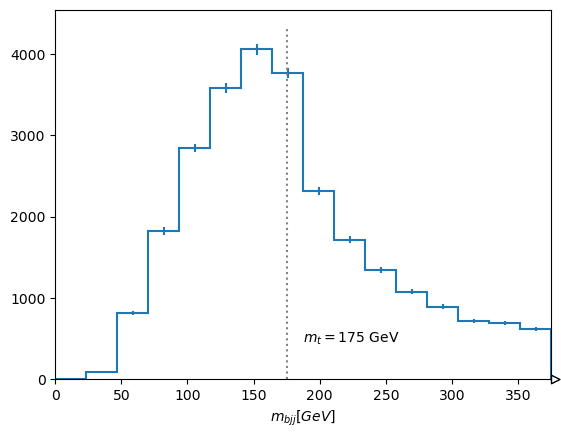

In [7]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175, 0, ax.get_ylim()[1], colors=["grey"], linestyle="dotted") 
ax.text(0.5, 0.1, "$m_{t} = 175$ GeV", transform = ax.transAxes)
ax.set_xlim([0, 375])

# Distributed computations

Now we will move to the distributed computations. The code below applies the same approach to the selection of the data and calculation of the mass of the trijets. The further code uses multiple PHYSLITE files which have the same structure of branches and are processed in a parallel way, after which the results are merged in the final histogram.

The files used for distributed calculations and their metadata are specified in the cell below. This particular case uses Monte Carlo generated data which can be accessed via the [link](https://opendata.cern.ch/record/80017). The corresponding metadata can be accessed via the [link](https://opendata.atlas.cern/docs/documentation/overview_data/data_research_2024/#metadata). Please refer to the comments in the file_utils.py file for more information. 

In this example, the files from the CERN server are cached wiht `xcache`, which allows for significant speed up data retrieval if the data is used repeatedly. The prefix to the data URL can be managed with the `XCACHE_PREFIX` variable in the cell below.

The metadata is read from the metadata.csv file during the importing of `file_utils`. All of the available metadata for specific processes is stored, but only some of them are used (see below), this redundancy affects performance very little but is much more favourable from the code flexibility and user-friendliness point of view. 

Additionally, the label of physicall process is added to the metadata dictionary in the cell below, this label is used during the drawing of the histogram.

## Monte Carlo-simulated physical processes of $t$ quarks producing.

The processes of producing single top quarks and mater-antimatter $t \bar{t}$ pairs were simulated in the input data for this analysis. The Feynman diagrams of the leading order for single top processes are described in the picture. The original of the picture is Ref. [1]

<div>
<img src="utils/Single_quark_process_diagrams.png" width="1000"/>
</div>
The diagrams shows single top production: (a) - t-channel, (b) - Wt -channel, (c) s-channel.


[1] Precision Measurements of Top Quark Production with the ATLAS Detector. Philipp  Stolte. EPJ Web Conf. 137 08015 (2017). [DOI:10.1051/epjconf/201713708015](https://doi.org/10.1051/epjconf/201713708015)


In [8]:
import file_utils

XCACHE_PREFIX = "root://xcache.af.uchicago.edu:1094//" # this could be an empty string

fileset = {
"singletop_schan_lept_top"  : 
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_singletop_schan_lept_top},
            'metadata': {**file_utils.metadata_singletop_schan_lept_top, "process-label":"single top s chan."},
            },
"singletop_schan_lept_antitop":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_singletop_schan_lept_antitop},
            'metadata': {**file_utils.metadata_singletop_schan_lept_antitop, "process-label":"single top s chan."},
            },
"tchan_BW50_lept_top":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_tchan_BW50_lept_top},
            'metadata': {**file_utils.metadata_tchan_BW50_lept_top, "process-label":"single top t chan."},
            },
"tchan_BW50_lept_antitop":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_tchan_BW50_lept_antitop},
            'metadata': {**file_utils.metadata_tchan_BW50_lept_antitop, "process-label":"single top t chan."},
            },
"tW_dyn_DR_incl_antitop":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_tW_dyn_DR_incl_antitop},
            'metadata': {**file_utils.metadata_tW_dyn_DR_incl_antitop, "process-label":"single top tW chan."},
            },
"tW_dyn_DR_incl_top":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_tW_dyn_DR_incl_top},
            'metadata': {**file_utils.metadata_tW_dyn_DR_incl_top, "process-label":"single top tW chan."},
            },
"ttbar_hdamp258p75_nonallhad":
            {
            'files': {XCACHE_PREFIX+name:'CollectionTree' for name in file_utils.filenames_ttbar_hdamp258p75_nonallhad},
            'metadata': {**file_utils.metadata_ttbar_hdamp258p75_nonallhad, "process-label":"$t \\bar{t}$"},
            }
}      
    
# Let's print the description from the metadata.
for file_dict in fileset.values():
    
    print("Physics: {phys:55s}| Description: {desc:s}".format(phys=file_dict["metadata"]["physics_short"], desc=file_dict["metadata"]["description"] ))
              
samples, _ = dataset_tools.preprocess(fileset)

Physics: PowhegPythia8EvtGen_A14_singletop_schan_lept_top       | Description: POWHEG+Pythia8+EvtGen single-top-quark s-channel production (top), inclusive, A14 tune, ME NNPDF30 NLO, A14 NNPDF23 LO'
Physics: PowhegPythia8EvtGen_A14_singletop_schan_lept_antitop   | Description: POWHEG+Pythia8+EvtGen single-top-quark s-channel production (anti-top), inclusive, A14 tune, ME NNPDF30 NLO, A14 NNPDF23 LO'
Physics: PhPy8EG_A14_tchan_BW50_lept_top                        | Description: POWHEG+Pythia8+EvtGen single-top-quark t-channel (2->3) production (top),MadSpin, A14 tune, ME NNPDF3.04f NLO, A14 NNPDF23 LO'
Physics: PhPy8EG_A14_tchan_BW50_lept_antitop                    | Description: POWHEG+Pythia8+EvtGen single-top-quark t-channel (2->3) production (top),MadSpin, A14 tune, ME NNPDF3.04f NLO, A14 NNPDF23 LO'
Physics: PhPy8EG_tW_dyn_DR_incl_antitop                         | Description: POWHEG+Pythia8+EvtGen tW production (antitop), DR scheme, dynamic scale, inclusive, hdamp equal 1.5*top ma




The code in the cell below defines the processing of a single input file, which is processed in parallel with others. As was mentioned above, the data processed in this particular example is Montecarlo-generated. Here we process files generated for several physical processes. The number of events generated for the specific physical process is arbitrary, to correctly show the different processes on the same histogram one needs to normalise data to the same luminosity, which is in our case `LUMINOSITY = 36100`. It is worth mentioning that the events in this Monte Carlo data are weighted. 

To make normalization of the data with weighted events to respond to the given luminosity the following formula was used.

`lumi_weight = LUMINOSITY * cross-section * k-factor * filter-efficiency / sum-of-mc-weights`

Here `cross-section`, `k-factor` and `filter-efficiency` are defined in metadata. The `sum-of-mc-weights` is calculated from the stored in the PHYSLITE file as the sum of Montecarlo-weights for each physical process.

The weight of each event during the filling histogram is `weight=lumi_weight*mc_weight`, where `lumi_weight` is constant and `mc_weight` is event specific (it is stored in the PHYSLITE file). 

In this code, the Monte Carlo-generated data for a single physical process can be split between multiple PHYSLITE files, each processed in parallel. For normalisation of the data one needs to divide weights on the `sum-of-mc-weights` across all events for a given physical process, but as the files are processed in parallel it is much more efficient to return the `sum-of-mc-weights` from the function which is doing the processing of single PHYSLITE file and divide each bin of the histogram on the `sum-of-mc-weights` outside of the parallel code. This approach is applied in the code below.

TODO: Add the reference for the numerical value of luminosity?

In [9]:
LUMINOSITY = 36100 

def create_histogram(events):

    reconstructed_top_mass, event_filters = calculate_trijet_mass_and_ev_filter(events)
        
    cross_section = events.metadata["crossSection_pb"]
    filter_efficiency = events.metadata["genFiltEff"]
    k_factor = events.metadata["kFactor"]
    process_label = events.metadata["process-label"]
    
    sum_of_mc_weights = ak.sum(events.EventInfo.mcEventWeights[:, 0])
    
    mc_weight = events.EventInfo.mcEventWeights[:, 0][event_filters]
    
    lumi_weight = LUMINOSITY * cross_section * k_factor * filter_efficiency
    
    hist_reco_mtop = (hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
                     .StrCat([], name="process", label="Process", growth=True)
                     .Weight()
                     .fill(reconstructed_top_mass/1000, weight=lumi_weight*mc_weight, process=process_label) )
    
    return {"hist":hist_reco_mtop, "sum_of_file_weights": sum_of_mc_weights}

The cell below attaches the files we prepared for parallel analysis to the dedicated function, `create_histogram` in our case. There we also specify branch filters and usage of `PHYSLITESchema`

In [10]:
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError), "filter_name": filter_name},
                                       )

The graph shows tasks for the histogram of the trijet mass of one of the physical processes considered.

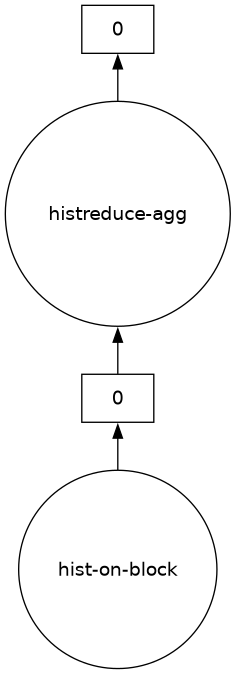

In [11]:
# Change the optimize_graph option to False to see a detailed graph.
tasks[0]["singletop_schan_lept_top"]["hist"].visualize(optimize_graph=True)

The code below runs computations for parallel processing of multiple files which were delayed. Here we divide the counts in histogram bit by the corresponding `sum-of-mc-weights` as well.

In [12]:
%%time

with performance_report(filename=MEASUREMENT_PATH/"dask-report-compute.html"):
    # execute
    ((out, report), ) = dask.compute(tasks)
    
    # Dividing the number of counts in each bin in the histogram by the sum of weights.
    for channel in out.keys():
        out[channel]["hist"] /= out[channel]["sum_of_file_weights"]
        
        # Refactoring the structure because it is not wise to have a dictionary with only one element.
        # And one does not need to have a sum of weights anymore.
        out[channel] = out[channel]["hist"]

CPU times: user 881 ms, sys: 44 ms, total: 925 ms
Wall time: 1min 49s


Let's print the reporting information of results of parallel computations

In [13]:
time_uproot = ak.sum([v['duration'] for v in report.values()])
print(f"total time spent in uproot reading data: {time_uproot:.2f} s")

total time spent in uproot reading data: 2796.99 s


And finally making the histogram from the distributed computing.

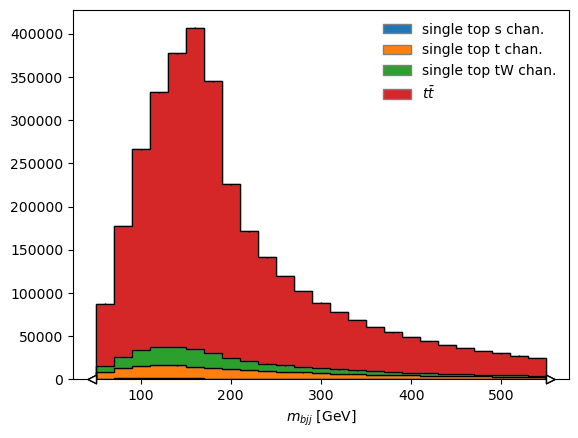

In [14]:
full_histogram_hist_mtop = sum([v for v in out.values()])


# Draw the filled stacked histograms
artists = full_histogram_hist_mtop.stack("process").plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)


# Draw the same histogram in the "step" style to get error bars on the same plot.
artists = full_histogram_hist_mtop.stack("process").plot(
    stack=True, histtype="step", linewidth=1, label="", color="black", yerr=True
)


ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)

The code in the next cell will save the hist build on the data from each channel into the file. Please note that there are different channels with the same process label, for example, channels `singletop_schan_lept_top` and `singletop_schan_lept_antitop` have the same process label, which is `single top s chan`

In [15]:
HIST_FILE_NAME = "histograms.root"

# Saving the histograms of each channel into the file.
with uproot.recreate(HIST_FILE_NAME) as f:
        
    # Declare empty pseudo data histogram which will be incremented on each cycle of the further loop.
    pseudodata_hist = 0
        
    for channel, histogram in out.items():
        
        # There is only one sample for each channel in our data.
        sample = histogram.axes[1][0]
        current_hist = histogram[:, sample]
        f[channel] = current_hist
        
        # Adding the current histogram to the pseudo data
        pseudodata_hist+=current_hist
        
    f["pseudodata"] = pseudodata_hist
                

TODO: Write a description of what cabinetry is doing.

In [16]:
cabinetry_config = cabinetry.configuration.load("cabinetry_config.yml") # The code crashes at this line

cabinetry.templates.collect(cabinetry_config, method="uproot")
cabinetry.templates.postprocess(cabinetry_config)

workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

variation override specified, but {VariationPath} not found in default path
variation override specified, but {VariationPath} not found in default path
variation override specified, but {VariationPath} not found in default path
variation override specified, but {VariationPath} not found in default path
variation override specified, but {VariationPath} not found in default path
variation override specified, but {VariationPath} not found in default path
variation override specified, but {VariationPath} not found in default path
variation override specified, but {VariationPath} not found in default path


W VariableMetricBuilder No improvement in line search


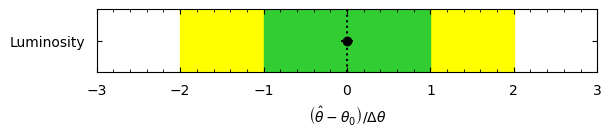

In [17]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

In [18]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")


fit result for ttbar_norm: 1.000 +/- 0.004


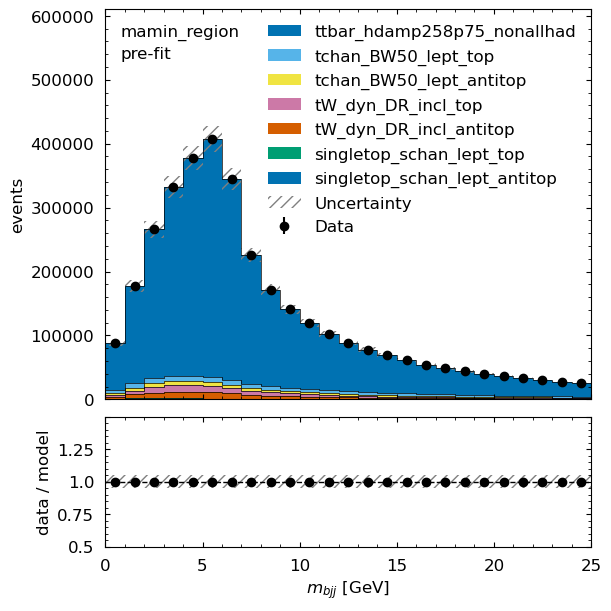

In [19]:
model_prediction = cabinetry.model_utils.prediction(model)
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction, data, config=cabinetry_config)
